# Importar TensorFlow e Bibliotecas necessárias

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, ReLU, LeakyReLU, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import backend as K
import numpy as np

import os
import pathlib
import matplotlib.pyplot as plt
import csv

from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd
import imageio
import glob
import time
from IPython import display
%matplotlib inline
import cv2


import collections

# Funções Auxiliares

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    m, v = enc(test_input, training=False)
    latent = final([m,  v])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')

    plt.savefig('fashion/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

# Carregar e preparar o dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.astype('float32')
#x_train = x_train / 255.
x_test = x_test / 255.
# Batch e fazer shuffle dos dados
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).\
shuffle(60000).batch(128)


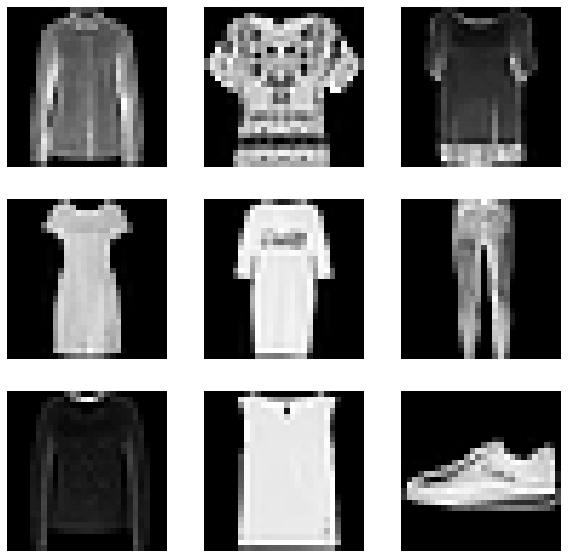

In [ ]:
plt.figure(figsize=(10, 10))
for images in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i,:,:,0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

# Configurações

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [ ]:
normalized_ds = train_dataset.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [ ]:
input_encoder = (28, 28, 1)
input_decoder = (2,)

In [ ]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    print(epsilon)
    return mean + K.exp(log_var / 2) * epsilon

In [ ]:
sampling_model

<function __main__.sampling_model>

# Definir Encoder

In [ ]:
def encoder(input_encoder):
  
    inputs = keras.Input(shape=input_encoder, name='input_layer')

    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
  
    # Block-4
    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
   
    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(2, name='mean')(flatten)
    log_var = layers.Dense(2, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [ ]:
enc = encoder(input_encoder)

In [ ]:
enc.output

(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'mean')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'log_var')>)

In [ ]:
#enc.save('vae-fashion-enc.h5')

# Definir Sampling Network

In [ ]:
input_1 = (2,)
input_2 = (2,)

In [ ]:
def sampling(input_1,input_2):
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [ ]:
final = sampling(input_1,input_2)

Tensor("encoder_output/random_normal:0", shape=(None, 2), dtype=float32)


In [ ]:
# final.save('sampling.h5')

# Definir o Decoder

In [ ]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(3136, name='dense_1')(inputs)
    x = layers.Reshape((7, 7, 64), name='Reshape_Layer')(x)
   
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block-3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # Block-4
    outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [ ]:
dec = decoder(input_decoder)

In [ ]:
# dec.save('vae-fashion-dec.h5')

# Optimizer e função de Loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)

def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    varkl_loss = kl_loss(mean, log_var)
    return  r_loss + varkl_loss

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
os.makedirs('fashion/training_weights', exist_ok=True)
os.makedirs('fashion/images', exist_ok=True)

# Treinar o VAE

In [ ]:
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
 
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                  epoch + 1,
                                  seed)
        enc.save_weights('fashion/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('fashion/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)

tf.Tensor(
[[ 1.0295807  -0.557746  ]
 [ 1.7888606   2.1655755 ]
 [ 1.6441828  -0.48512495]
 [-1.5839143   0.7622374 ]
 [ 0.64062613  1.0945383 ]
 [-0.8134428   1.042777  ]
 [ 0.80109906  0.36839634]
 [ 1.1113083  -0.10451369]
 [-1.3298469   1.603768  ]
 [ 1.1491189   2.1967976 ]
 [-1.4130782   1.3696198 ]
 [ 0.84047425 -0.84131426]
 [-2.1033807  -0.0054421 ]
 [ 0.47797132  1.8882996 ]
 [-0.5515232  -0.33097908]
 [-1.7531039   0.55957705]
 [-0.08413002 -0.34726584]
 [-0.4284719   1.5705868 ]
 [-0.10816126  1.4472191 ]
 [ 1.245133    1.1431113 ]
 [ 0.3319387   2.2727473 ]
 [-2.294506   -1.8756561 ]
 [-0.02960551 -0.25020385]
 [ 0.1548291  -1.2464991 ]
 [-0.03547772 -0.72539103]], shape=(25, 2), dtype=float32)
(25, 28, 28, 1)


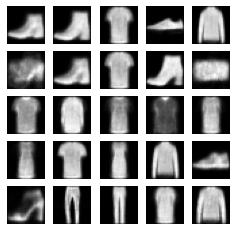

In [ ]:
train(normalized_ds, 25)

# Load dos pesos

In [ ]:
enc.load_weights('fashion/training_weights/enc_24.h5')
dec.load_weights('fashion/training_weights/dec_24.h5')

# Resultados

In [ ]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

Reconstruir através de um vetor de latentes

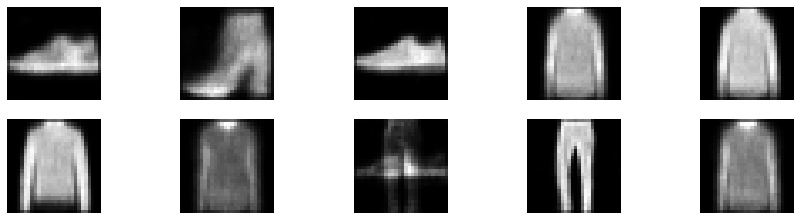

In [ ]:
figsize = 15

x = np.random.normal(size = (10,2))
#x = np.random.uniform(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow(reconstruct[i, :,:,0]*255, cmap = 'gray')

Reconstuir através do set de testes

tf.Tensor(
[[ 1.3993096   0.3797263 ]
 [ 0.2807128  -0.89685345]
 [ 1.4186985   0.14058484]
 [ 1.0828744  -0.04841368]
 [ 1.1899732  -0.7973679 ]
 [-1.3003575  -1.4416442 ]
 [-2.4525552  -0.63454336]
 [ 0.5956231   0.5041341 ]
 [ 0.36278236 -1.1710256 ]
 [ 0.75916445  0.15079913]
 [ 1.0046477   0.50602454]
 [-1.2919978  -1.4091156 ]
 [-1.0563614   0.56867284]
 [-0.23638377  0.39017418]
 [-0.6951189   0.4052793 ]
 [ 0.1138399   0.59913486]
 [-1.6210603   0.12948288]
 [-1.6241211   0.5917921 ]
 [-0.21054962  1.7738178 ]
 [ 0.15288612  0.76619273]
 [-0.35490003  0.06249958]
 [ 0.25883526  0.19898169]
 [-0.83027786 -0.5617517 ]
 [-2.2855647  -0.03322942]
 [-1.3560567   0.6160971 ]], shape=(25, 2), dtype=float32)


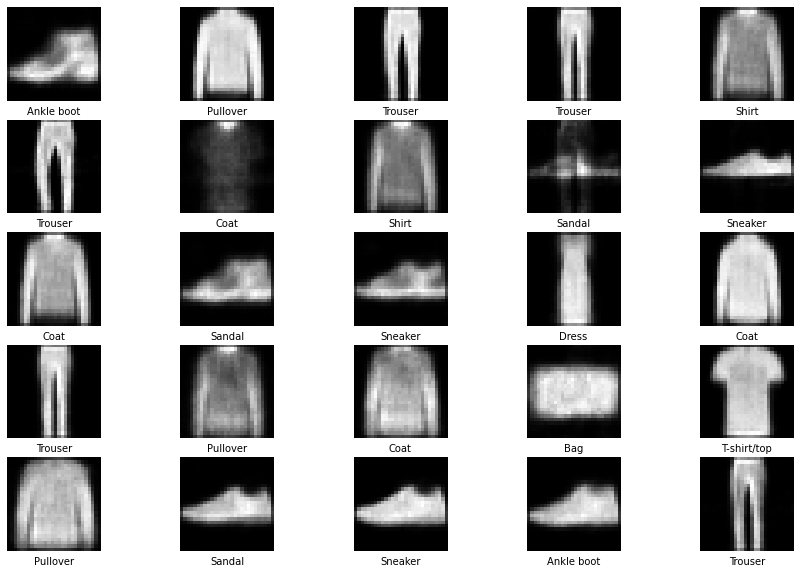

In [ ]:
figsize = 15

m, v = enc.predict(x_test[:25])
latent = final([m,v])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(label_dict[y_test[i]]), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')